## Mentions
* [StackExchange: Spearman weighted by errors](https://stats.stackexchange.com/questions/235418/how-to-weight-a-spearman-rank-correlation-by-statistical-errors) 

In [1]:
from os.path import exists, join
import pandas as pd


def make_multilevel(potential, certainty):
    """Combine Potential and Certainty into a multilevel dataframe."""
    
    certainty_t = certainty.transpose()
    certainty_t['level'] = ['certainty'] * 10

    potential_t = potential.transpose()
    potential_t['level'] = ['potential'] * 10
    
    both = pd.concat([certainty_t, potential_t])
    both = both.groupby(['Criterion', 'level']).agg(lambda x: x)
    both = both.transpose()
    
    return both

def get_mles(sample):
    """Where sample takes 3 values: {0, 1, 2}."""
    n = len(sample)
    mles = (sample.eq(0).sum() / n, sample.eq(1).sum() / n, sample.eq(2).sum() / n)
    return mles

def naneuclidean_similarity(col1, col2):
    """Requires normalised data. Not bounded. For use with DatFrame.corr function."""
    # count number present/missing
    P = len(col1)
    
    # get metric
    euclidean_dist = np.sqrt((N / P) * ((col1 - col2) ** 2).sum())
    return 1 / (1 + euclidean_dist)

def cosine_similarity(col1, col2):
    """Not bounded. For use with DatFrame.corr function."""
    P = len(col1)
    
    if (col1.sum() == 0) or (col2.sum() == 0):
        return np.nan
    
    return (col1 * col2).sum() / ( np.sqrt((col1 ** 2).sum()) * np.sqrt((col2 ** 2).sum()))

In [3]:
criteria_dict

{17: 'Home range',
 18: 'Depth range',
 29: 'Migration',
 30: 'Reproduction',
 31: 'Aggregation',
 32: 'Aggression',
 33: 'Substrate',
 34: 'Stress',
 35: 'Malformation',
 36: 'Slaughter'}

In [2]:
wd = join('..', '..', 'data')
df = pd.read_csv(join(wd, 'feb_farm_data_s2.csv'))

# get criterion dictionary
criteria_df = df.head(10)[['Criterion.1', 'Unnamed: 7']].set_index('Criterion.1')
criteria_df.index.name = 'index'
criteria_df.columns = ['criterion']
criteria_dict = {int(val): name for val, name in zip(criteria_df.index, criteria_df['criterion'])}
criteria_dict_r = {value: key for key, value in criteria_dict.items()}

# set up dataframe for each of likelihood, potential, and uncertainty
likelihood = df.pivot(index="Fish ID", columns="Criterion", values="Likelihood")
potential = df.pivot(index="Fish ID", columns="Criterion", values="Potential")
certainty = df.pivot(index="Fish ID", columns="Criterion", values="Certainty")

# combine into one multiindex df (useful for operations later)
both = make_multilevel(potential, certainty)

# make a multilevel dataframe and remove negative values
idx = pd.IndexSlice
both = both.applymap(lambda x: np.nan if x < 0 else x)
potential = both.loc[:, idx[:, 'potential']].droplevel('level', axis=1)

# get normalised rank transformations (to use with quantitative distance measures such as Euclidean)
potential_z = (potential) / (3 - 1)

NameError: name 'np' is not defined

### Basic bootstrap
Not accounting for similarity or NaNs, but bootstrapping to get confidence intervals for the correlation.

In [208]:
criteria_dict

{17: 'Home range',
 18: 'Depth range',
 29: 'Migration',
 30: 'Reproduction',
 31: 'Aggregation',
 32: 'Aggression',
 33: 'Substrate',
 34: 'Stress',
 35: 'Malformation',
 36: 'Slaughter'}

Mean similarity: 0.41 with standard error 0.23


(0.4114707157192254, 0.23003266396818917)

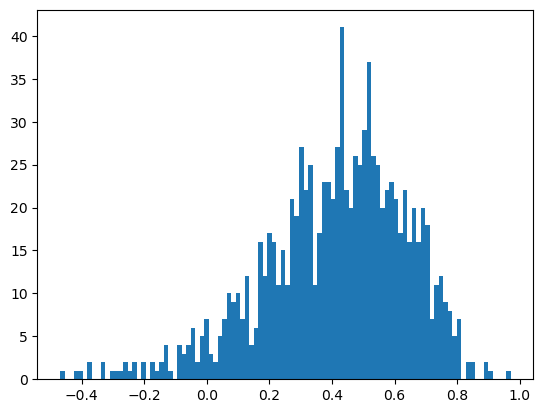

In [213]:
def bootstrap(measure, cols, B=1000, n=30, simfunc='spearman', plot=True):

    N = len(measure)
    similarities = []

    for b in range(B):
        sample = measure.sample(n, replace=True)
        similarity = sample.corr(method=simfunc).loc[cols[0], cols[1]]
        similarities.append(similarity)

    mean_sim = np.nanmean(similarities)
    se_sim = np.nanstd(similarities)

    print(f"Mean similarity: {mean_sim:.2f} with standard error {se_sim:.2f}")
    if plot:
        plt.hist(similarities, bins=100);
        
    return mean_sim, se_sim

bootstrap(potential, (17, 18))

# MLE stuff (leaving be)

In [90]:
# Get the error bars for v1
low = v1[v1.certainty == 0]['potential']
medium = v1[v1.certainty == 1]['potential']
high = v1[v1.certainty == 2]['potential']



In [120]:
level, level_string = (low, 'low')

B = 1000  # number of bootstrap samples
n = 5     # sample size

low_mles = []
medium_mles = []
high_mles = []

for b in range(B):
    sample = level.sample(n, replace=True)
    low_mle, medium_mle, high_mle = get_mles(sample)
    low_mles.append(low_mle)
    medium_mles.append(medium_mle)
    high_mles.append(high_mle)
    
plow_mle = level.eq(0).sum() / len(level)
pmedium_mle = level.eq(1).sum() / len(level)
phigh_mle = level.eq(2).sum() / len(level)

plow_std = np.std(low_mles)
pmedium_std = np.std(medium_mles)
phigh_std = np.std(high_mles)

print(f"Distribution for Potential, given {level_string} certainty")
print(f"MLE (p0, p1, p2)=({plow_mle:.2f}, {pmedium_mle:.2f}, {phigh_mle:.2f})")
print(f"with standard errors ({plow_std:.2f}, {pmedium_std:.2f}, {phigh_std:.2f})")

Distribution for Potential, given low certainty
MLE (p0, p1, p2)=(0.06, 0.11, 0.00)
with standard errors (0.10, 0.14, 0.00)


In [122]:
level, level_string = (medium, 'medium')

B = 1000  # number of bootstrap samples
n = 5     # sample size

low_mles = []
medium_mles = []
high_mles = []

for b in range(B):
    sample = level.sample(n, replace=True)
    low_mle, medium_mle, high_mle = get_mles(sample)
    low_mles.append(low_mle)
    medium_mles.append(medium_mle)
    high_mles.append(high_mle)
    
plow_mle = level.eq(0).sum() / len(level)
pmedium_mle = level.eq(1).sum() / len(level)
phigh_mle = level.eq(2).sum() / len(level)

plow_std = np.std(low_mles)
pmedium_std = np.std(medium_mles)
phigh_std = np.std(high_mles)

print(f"Distribution for Potential, given {level_string} certainty")
print(f"MLE (p0, p1, p2)=({plow_mle:.2f}, {pmedium_mle:.2f}, {phigh_mle:.2f})")
print(f"with standard errors ({plow_std:.2f}, {pmedium_std:.2f}, {phigh_std:.2f})")

Distribution for Potential, given medium certainty
MLE (p0, p1, p2)=(0.22, 0.43, 0.13)
with standard errors (0.19, 0.23, 0.15)


In [121]:
level, level_string = (high, 'high')

B = 1000  # number of bootstrap samples
n = 5     # sample size

low_mles = []
medium_mles = []
high_mles = []

for b in range(B):
    sample = level.sample(n, replace=True)
    low_mle, medium_mle, high_mle = get_mles(sample)
    low_mles.append(low_mle)
    medium_mles.append(medium_mle)
    high_mles.append(high_mle)
    
plow_mle = level.eq(0).sum() / len(level)
pmedium_mle = level.eq(1).sum() / len(level)
phigh_mle = level.eq(2).sum() / len(level)

plow_std = np.std(low_mles)
pmedium_std = np.std(medium_mles)
phigh_std = np.std(high_mles)

print(f"Distribution for Potential, given {level_string} certainty")
print(f"MLE (p0, p1, p2)=({plow_mle:.2f}, {pmedium_mle:.2f}, {phigh_mle:.2f})")
print(f"with standard errors ({plow_std:.2f}, {pmedium_std:.2f}, {phigh_std:.2f})")

Distribution for Potential, given high certainty
MLE (p0, p1, p2)=(0.69, 0.23, 0.08)
with standard errors (0.20, 0.18, 0.12)


### Weighted Spearman rank correlation
[Stack exchange here](https://stats.stackexchange.com/questions/235418/how-to-weight-a-spearman-rank-correlation-by-statistical-errors)